<a href="https://colab.research.google.com/github/nyp-sit/it3103/blob/main/week2/mnist_keras_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab Exercise 2: Hello World Deep Learning Model (Solution)

This guide trains a neural network model to classify images of clothing, like sneakers and shirts. It's okay if you don't understand all the details; this is a fast-paced overview of a complete TensorFlow program with the details explained as you go.

This guide uses [tf.keras](https://www.tensorflow.org/guide/keras), a high-level API to build and train models in TensorFlow.

In [19]:
# TensorFlow and tf.keras
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow.keras as keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.4.1


## Import the Fashion MNIST dataset

This guide uses the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset which contains 70,000 grayscale images in 10 categories. The images show individual articles of clothing at low resolution (28 by 28 pixels), as seen here:

<table>
  <tr><td>
    <img src="https://tensorflow.org/images/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite"  width="600">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1.</b> <a href="https://github.com/zalandoresearch/fashion-mnist">Fashion-MNIST samples</a> (by Zalando, MIT License).<br/>&nbsp;
  </td></tr>
</table>


Here, 60,000 images are used to train the network and 10,000 images to evaluate how accurately the network learned to classify images. You can access the Fashion MNIST directly from TensorFlow. Import and load the Fashion MNIST data directly from TensorFlow:

In [11]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

Loading the dataset returns four NumPy arrays:

* The `train_images` and `train_labels` arrays are the *training set*—the data the model uses to learn.
* The model is tested against the *test set*, the `test_images`, and `test_labels` arrays.

The images are 28x28 NumPy arrays, with pixel values ranging from 0 to 255. The *labels* are an array of integers, ranging from 0 to 9. These correspond to the *class* of clothing the image represents:

<table>
  <tr>
    <th>Label</th>
    <th>Class</th>
  </tr>
  <tr>
    <td>0</td>
    <td>T-shirt/top</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Trouser</td>
  </tr>
    <tr>
    <td>2</td>
    <td>Pullover</td>
  </tr>
    <tr>
    <td>3</td>
    <td>Dress</td>
  </tr>
    <tr>
    <td>4</td>
    <td>Coat</td>
  </tr>
    <tr>
    <td>5</td>
    <td>Sandal</td>
  </tr>
    <tr>
    <td>6</td>
    <td>Shirt</td>
  </tr>
    <tr>
    <td>7</td>
    <td>Sneaker</td>
  </tr>
    <tr>
    <td>8</td>
    <td>Bag</td>
  </tr>
    <tr>
    <td>9</td>
    <td>Ankle boot</td>
  </tr>
</table>

Each image is mapped to a single label. Since the *class names* are not included with the dataset, store them here to use later when plotting the images:

In [12]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

## Explore the data

Let's explore the format of the dataset before training the model. The following shows there are 60,000 images in the training set, with each image represented as 28 x 28 pixels:

In [13]:
train_images.shape

(60000, 28, 28)

Likewise, there are 60,000 labels in the training set:

In [14]:
len(train_labels)

60000

Let's just print out the values of the labels for the first 20 samples. We can see that each label is an integer between 0 and 9. We can also see that the training samples are already randomly shuffled, so we don't need to shuffle them. It is always a good practice to shuffle your training data (in most cases) to enable your ML model to learn correctly.

In [5]:
train_labels[:20]

array([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9, 1, 0, 6, 4],
      dtype=uint8)

There are 10,000 images in the test set. Again, each image is represented as 28 x 28 pixels:

In [6]:
test_images.shape

(10000, 28, 28)

And the test set contains 10,000 images labels:

In [7]:
len(test_labels)

10000

we further split the training data into train and validation set

In [15]:
orig_train_images, orig_train_labels = train_images.copy(), train_labels.copy()
train_images, train_labels = orig_train_images[:50000], orig_train_labels[:50000]
val_images, val_labels = orig_train_images[50000:], orig_train_labels[50000:]
print(len(train_images), len(val_images))

50000 10000


## Preprocess the data

The data must be preprocessed before training the network. If you inspect the first image in the training set, you will see that the pixel values fall in the range of 0 to 255:

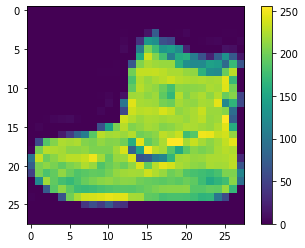

In [16]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

Scale these values to a range of 0 to 1 before feeding them to the neural network model. To do so, divide the values by 255. It's important that the *training set* and the *testing set* be preprocessed in the same way:

In [17]:
train_images = train_images / 255.0

test_images = test_images / 255.0

val_images = val_images / 255.0

To verify that the data is in the correct format and that you're ready to build and train the network, let's display the first 25 images from the *training set* and display the class name below each image.

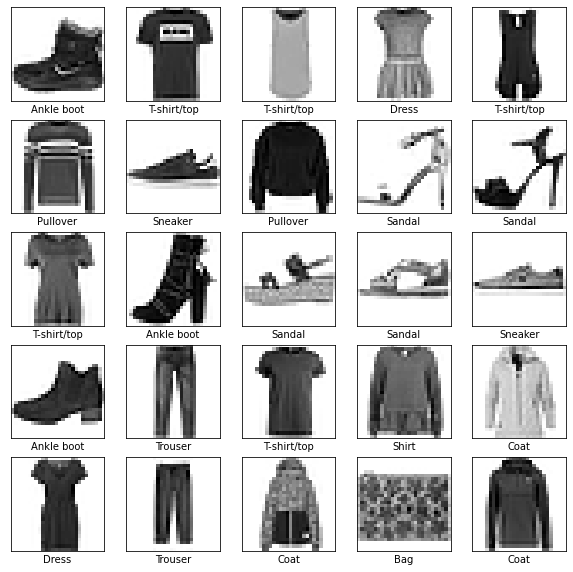

In [18]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])  # pass empty array will remove the xticks
    plt.yticks([])  # pass empty array will remove the yticks
    plt.grid(False)
    plt.imshow(train_images[i],cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

## Build the model

Building the neural network requires configuring the layers of the model, then compiling the model.

### Set up the layers

The basic building block of a neural network is the *layer*. Layers extract representations from the data fed into them. Hopefully, these representations are meaningful for the problem at hand.

Most of deep learning consists of chaining together simple layers. For our simple model, we can use the Sequential model to chain multiple layers together. 

Most layers, such as `tf.keras.layers.Dense`, have parameters that are learned during training.

**Exercise 1**

Write the code to construct a neural network that consists of the following:

- The first layer in this network, `tf.keras.layers.Flatten`, transforms the format of the images from a two-dimensional array (of 28 by 28 pixels) to a one-dimensional array (of 28 * 28 = 784 pixels). Think of this layer as unstacking rows of pixels in the image and lining them up. This layer has no parameters to learn; it only reformats the data.

- After the pixels are flattened, the network consists of a sequence of two `tf.keras.layers.Dense` layers. These are densely connected, or fully connected, neural layers. The first `Dense` layer has 128 nodes (or neurons). The second (and last) layer returns a logits array with length of 10. Each node contains a probability score that indicates how likely is the current image belongs to one of the 10 classes. We will use a softmax function to ensure the probability adds up to 1.0.

- Use appropriate activation function for each layer


In [21]:
## TODO: Complete the code below to build the model ##
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Sequential

model = Sequential()
model.add(Flatten(input_shape=(28,28)))
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))



### Compile the model

Before the model is ready for training, it needs a few more settings. These are added during the model's *compile* step:

* *Loss function* —This measures how accurate the model is during training. You want to minimize this function to "steer" the model in the right direction.
* *Optimizer* —This is how the model is updated based on the data it sees and its loss function. In our case, we will just use Adam. 
* *Metrics* —Used to monitor the training and testing steps. In our case, we want to monitor *accuracy*, the fraction of the images that are correctly classified. 


**Exercise 2:**

Write the code to compile the model with  appropriate loss function suitable for our problem. 

*Hint:* You need to know how you encode your target labels.




In [23]:
### Write your code here to compile the model 

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

## Train the model

Training the neural network model requires the following steps:

1. Feed the training data to the model. In this example, the training data is in the `train_images` and `train_labels` arrays.
2. The model learns to associate images and labels.
3. You ask the model to make predictions about a test set—in this example, the `test_images` array.
4. Verify that the predictions match the labels from the `test_labels` array.


### Feed the model with training data

To start training,  call the `model.fit` method—so called because it "fits" the model to the training data:

In [24]:
history = model.fit(train_images, train_labels, validation_data = (val_images, val_labels), epochs=30)

Epoch 1/30
1563/1563 [==============================] - 7s 2ms/step - loss: 0.6570 - accuracy: 0.7706 - val_loss: 0.4384 - val_accuracy: 0.8381
Epoch 2/30
1563/1563 [==============================] - 4s 2ms/step - loss: 0.3921 - accuracy: 0.8604 - val_loss: 0.3737 - val_accuracy: 0.8663
Epoch 3/30
1563/1563 [==============================] - 4s 2ms/step - loss: 0.3410 - accuracy: 0.8764 - val_loss: 0.3640 - val_accuracy: 0.8671
Epoch 4/30
1563/1563 [==============================] - 4s 2ms/step - loss: 0.3277 - accuracy: 0.8781 - val_loss: 0.3315 - val_accuracy: 0.8814
Epoch 5/30
1563/1563 [==============================] - 4s 2ms/step - loss: 0.2979 - accuracy: 0.8917 - val_loss: 0.3339 - val_accuracy: 0.8780
Epoch 6/30
1563/1563 [==============================] - 4s 2ms/step - loss: 0.2817 - accuracy: 0.8957 - val_loss: 0.3300 - val_accuracy: 0.8819
Epoch 7/30
1563/1563 [==============================] - 4s 2ms/step - loss: 0.2639 - accuracy: 0.9005 - val_loss: 0.3415 - val_accuracy:

In [25]:
def plot_training_progress(train_metric, train_label, val_metric=None, val_label=None):
    epochs = range(1, len(train_metric) + 1)
    plt.plot(epochs, train_metric, 'b', label=train_label)
    if val_metric:
        plt.plot(epochs, val_metric, 'r', label=val_label)
        
    #plt.title('Training loss')
    plt.legend()
    plt.show()
    

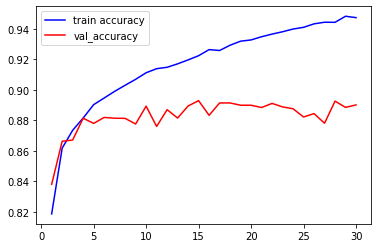

In [26]:
plot_training_progress(history.history['accuracy'], 'train accuracy', 
                   history.history['val_accuracy'], 'val_accuracy')

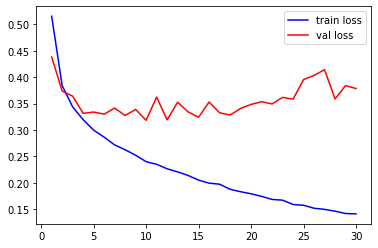

In [27]:
plot_training_progress(history.history['loss'], 'train loss', 
                   history.history['val_loss'], 'val loss')

As the model trains, the loss and accuracy metrics are displayed. This model reaches an accuracy of about 0.91 (or 91%) on the training data.

**Exercise 3:** 

- What is the accuracy achieved by validation data? 
96%, 89%

- Is there any overfitting?

Yes

### Evaluate accuracy on Test samples

Next, compare how the model performs on the test dataset:

In [28]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

313/313 - 0s - loss: 0.4213 - accuracy: 0.8792

Test accuracy: 0.8791999816894531


It turns out that the accuracy on the test dataset (and also validation dataset) is a little less than the accuracy on the training dataset. This gap between training accuracy and test accuracy represents *overfitting*. Overfitting happens when a machine learning model performs worse on new, previously unseen inputs than it does on the training data. An overfitted model "memorizes" the noise and details in the training dataset to a point where it negatively impacts the performance of the model on the new data. For more information, see the following:
*   [Demonstrate overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit#demonstrate_overfitting)
*   [Strategies to prevent overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit#strategies_to_prevent_overfitting)

### Make predictions

With the model trained, you can use it to make predictions about some images.
The model's linear outputs, [logits](https://developers.google.com/machine-learning/glossary#logits). Attach a softmax layer to convert the logits to probabilities, which are easier to interpret. 

In [30]:
preds = model.predict(test_images)

In [36]:
print(preds[0])

[2.3992017e-12 7.4097846e-14 7.5544931e-13 4.3441498e-17 1.0309158e-12
 1.1750569e-08 3.2823972e-09 2.5728135e-05 6.6840851e-12 9.9997425e-01]


Here, the model has predicted the label for each image in the testing set. Let's take a look at the first prediction:

In [33]:
print(tf.reduce_sum(preds[0]))


tf.Tensor(1.0, shape=(), dtype=float32)


You will notice that the prediction is not a single label that tell you what is the clothing object. Instead you get an array of 10 numbers. They represent the model's "confidence" that the image corresponds to each of the 10 different articles of clothing. You can see which label has the highest confidence value.


You can use [``np.argmax()``](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html) to find the index of the probabilities with the maximum value (maximum confidence).

In [37]:
np.argmax(preds[0])

9

So, the model is most confident that this image is an ankle boot, or `class_names[9]`. Examining the test label shows that this classification is correct:

In [39]:
test_labels[0]

9

Graph this to look at the full set of 10 class predictions.

In [40]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

### Verify predictions

With the model trained, you can use it to make predictions about some images.

Let's look at the 0th image, predictions, and prediction array. Correct prediction labels are blue and incorrect prediction labels are red. The number gives the percentage (out of 100) for the predicted label.

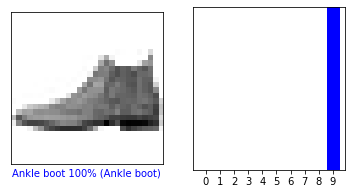

In [41]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, preds[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, preds[i],  test_labels)
plt.show()

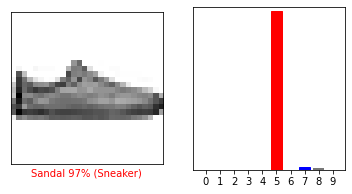

In [42]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, preds[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, preds[i],  test_labels)
plt.show()

Let's plot several images with their predictions. Note that the model can be wrong even when very confident.

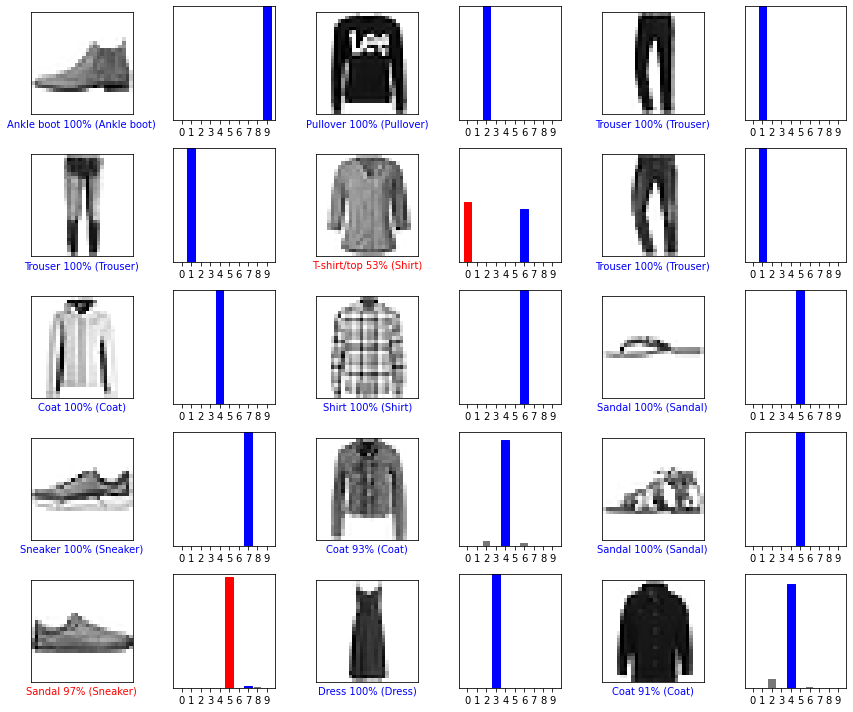

In [43]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, preds[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, preds[i], test_labels)
plt.tight_layout()
plt.show()

## Save the model 

We will now save our model which can be used for inference later on. In this example we will use the SavedModel format, which includes the weights and the model definition.



In [44]:
model.save('fmnist_model')

INFO:tensorflow:Assets written to: fmnist_model/assets


## Using the trained model for inference

We will now use our saved model to to make a prediction about a single image.

We will need to first load our trained model from the SavedModel.


In [ ]:
saved_model = tf.keras.models.load_model('fmnist_model')


In [ ]:

# Grab an image from the test dataset.
img = test_images[1]

print(img.shape)

In [ ]:
plt.imshow(img)

`tf.keras` models are optimized to make predictions on a *batch*, or collection, of examples at once. Accordingly, even though you're using a single image, you need to add it to a list:

In [ ]:
# Add the image to a batch where it's the only member.
img = (np.expand_dims(img,0))

print(img.shape)

Now predict the correct label for this image:

In [ ]:
preds_single = saved_model.predict(img)

print(preds_single)

In [ ]:
plot_value_array(1, preds_single[0], test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)

`tf.keras.Model.predict` returns a list of lists—one list for each image in the batch of data. Grab the predictions for our (only) image in the batch:

In [ ]:
np.argmax(preds_single[0])

And the model predicts a label as expected.

In [ ]:
##

## Using Tensorboard for visualization

We can use Tensorboard to visualize our training metrics (loss/accuracy) in realtime. The code below shows how you launch tensorboard within the Jupyter notebook by using the tensorboard extension in Juypter notebook.

In [ ]:
import os 

root_logdir = os.path.join(os.curdir, "tb_logs")

def get_run_logdir():    # use a new directory for each run
	import time
	run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
	return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()

tb_callback = tf.keras.callbacks.TensorBoard(run_logdir)


In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])


In [ ]:
model.fit(train_images, train_labels, 
          validation_data = (val_images, val_labels), 
          epochs=10,
          callbacks=[tb_callback])

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
%tensorboard --logdir tb_logs

**Exercise 4:**

Change the code above to train for 30 epochs.  What do you observe about training loss/accuracy and validation loss/accuracy? 

Write your answer here:

*your answer*

**Exercise 5:**

Let's now look at the layers in your model. Experiment with different number of neurons (width) and different number of layers (depth). What different results do you get for loss and accuracy, training time etc? Why do you think that's the case?



In [ ]:
### TODO:  Write the code to construct a new model with different width and depth and train the model. 
### Evaluate the model




**Exercise 6:**

Before you trained, you normalized the data, going from values that were 0-255 to values that were 0-1. What would be the impact of removing that? Experiment with this in the code cell below.

Why do you think you get different results? Write your answer below in this text cell.

*Answer here*

In [ ]:
### TODO: Write the code here to experiment with no normalization ### 



**Exercise 7:**

Modify the code to stop training early when there is no more improvement in the validation accuracy, and restore the weights to the best model.


In [ ]:
### TODO: Write the code here to implement early stopping ### 